Devoir #3
Entraînement d'un PMC, d'un réseau de neurones profond de type CNN et transfert d'apprentissage

Mercier Anna-Eve

# Partie 1

2.1 Entaînement d'un classeur binaire et multi-classes pour la vente en ligne avec scikit-learn

Imports

In [10]:
import numpy as np
import os
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, recall_score, precision_score, f1_score, make_scorer, roc_curve, auc, accuracy_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
pd.options.mode.chained_assignment = None

In [11]:
filepath_dataset = "dataset"

customer = "Customer.csv"
country_pop = "CountryPopulation.csv"
country_gdp = "CountryGDP.csv"

test_train_ratio = 0.2
random_state_seed = 42

sans_merge = False
merge_gdp = False

Cleaning up data from the previous TP correction

In [12]:
#### Fonction de bornage des données aberrantes (outliers)
def nettoyageOutliers(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.columns

    #Calcul de l'écart interquartile
    Q25 = df[cols].quantile(0.25)  #Q1 on définit le premier quartile pour c
    Q75 = df[cols].quantile(0.75)
    IQR = Q75 - Q25

    #Calcul des bornages inférieurs et supérieurs à l'IQR
    SeuilMin = (Q25 - 1.5 * IQR)
    SeuilMax = (Q75 + 1.5 * IQR)

    # Remplacer les outliers à l'extérieur des bornes IQR par les valeurs correspondantes
    nouv_df = df[cols].clip(SeuilMin[cols], SeuilMax[cols], axis=1)
    return nouv_df

def bornage(data):
    return nettoyageOutliers(pd.DataFrame(data))

#### Fonction de concaténation (merge) des ensembles de données
def mergeDataset(data, pop=False, pib=False):
    # S'assurer que c'est bien un DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    # Cas sans merge
    if pop:
        return data

    # Fusion avec data_pays
    data_enrichie = pd.merge(data, data_pays, on='country', how='left')

    # Si PIB demandé
    if pib:
        data_enrichie = data_enrichie.merge(data_pib, on='country', how='left')

    return data_enrichie

#### Fonction de conversion de caractéristiques au format numérique
def toNum(data: pd.DataFrame):
    data['first_item_prize'] = pd.to_numeric(data['first_item_prize'])
    return data

### Pipeline de traitement des données numériques
num_transformer = Pipeline([
    ('toNum', FunctionTransformer(toNum, validate=False)),
    # Nettoyage par remplacement de valeurs manquantes
    ('imputer', SimpleImputer(strategy="median")),
    # Remplacement des données aberrantes
    ('clamp', FunctionTransformer(bornage, validate=False))
])

### Pipeline de traitement des données catégorielles
cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### Pipeline de tranformation des données numériques et catégorielles
preparationData = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', cat_transformer, make_column_selector(dtype_exclude=np.number))
    ]
)

### Pipeline complet
full_pipeline = Pipeline([
    ('preparation', preparationData),
    ('standard_scaler', StandardScaler())
])

In [13]:
data_client = pd.read_csv(os.path.join(filepath_dataset, customer), na_values=['?', 'unknown'])

data_pays = pd.read_csv(os.path.join(filepath_dataset, country_pop), na_values=['?', 'unknown'])
data_pays.columns = ['country', 'population']

data_pib = pd.read_csv(os.path.join(filepath_dataset, country_gdp), na_values=['?', 'unknown'])
data_pib.columns = ['country', 'GDP_inhab']

Verification of dataset cleaning

In [14]:
df_merged = pd.merge(data_client, data_pays, on='country', how='left')
customer = pd.merge(df_merged, data_pib, on='country', how='left')

print(customer.info())
print(customer.head())
print(customer.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               10000 non-null  float64
 1   pages             10000 non-null  float64
 2   first_item_prize  9997 non-null   float64
 3   gender            10000 non-null  object 
 4   ReBuy             10000 non-null  bool   
 5   News_click        10000 non-null  float64
 6   country           10000 non-null  object 
 7   revenue           9996 non-null   float64
 8   population        10000 non-null  int64  
 9   GDP_inhab         10000 non-null  int64  
dtypes: bool(1), float64(5), int64(2), object(2)
memory usage: 713.0+ KB
None
    age  pages  first_item_prize gender  ReBuy  News_click country  revenue  \
0  41.0    6.0              28.0    Fem  False         4.0   China    113.0   
1  34.0    4.0              15.5    Fem   True         2.0   China     36.0   
2  38.0    5.

In [15]:
customer_transformed = full_pipeline.fit_transform(customer)

cat_cols = full_pipeline.named_steps['preparation'] \
    .named_transformers_['cat']['encoder'].get_feature_names_out(
        customer.select_dtypes(exclude=np.number).columns
    )

num_cols = customer.select_dtypes(include=np.number).columns
columns = np.concatenate([num_cols, cat_cols])
customer = pd.DataFrame(customer_transformed, columns=columns)


2.1.1 and 2.2.2 Trainning of a MLP

Separation of data into test and training data

In [17]:
counts = y.value_counts()
valid_classes = counts[counts >= 2].index

X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Model creation and training on model separation into 2 classes and 3 classes with accuracy calculation

In [18]:
model = MLPClassifier()

param_distributions = {
    'hidden_layer_sizes': [
    (10,), (25,), (50,), (75,), (100,),
    (10,10), (25,25), (50,50), (75,75), (100,100),
    (20,10), (50,25), (100,50), (75,25), (100,10),
    (10,10,10), (25,25,25), (50,50,50), (75,75,75), (100,100,100),
    (20,10,5), (50,25,10), (100,50,25), (75,50,25), (100,75,50),
    (100,50,25,10), (75,50,25,10), (50,25,10,5),
    (100,75,50,25), (50,50,25,10), (100,50,10,50),
    (100,75,50,25,10), (50,50,25,10,5), (75,50,25,10,5),
    (100,50,25,10,50), (50,25,10,25,50), (50,50,10,100,100)],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh', 'logistic'],
    'max_iter': [200, 500, 800]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=40,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


# For 2 classes
bins_2 = [-np.inf, 0, np.inf]
labels_2 = [0, 1]

y_train_2 = pd.cut(y_train, bins=bins_2, labels=labels_2)
y_test_2 = pd.cut(y_test, bins=bins_2, labels=labels_2)

random_search.fit(X_train,  y_train_2)

results_2 = pd.DataFrame(random_search.cv_results_)
print(results_2[['params', 'mean_test_score', 'rank_test_score']])

print("Best Parameters 2 class:", random_search.best_params_)
best_model_2 = random_search.best_estimator_
accuracy_2 = best_model_2.score(X_test, y_test_2)
print("Test Set Accuracy 2 class:", accuracy_2)




# For 3 classes
bins_3 = [-np.inf, -1, 0, np.inf]
labels_3 = ['bas', 'moyen', 'émevé']

y_train_3 = pd.cut(y_train, bins=bins_3, labels=labels_3)
y_test_3 = pd.cut(y_test, bins=bins_3, labels=labels_3)

random_search.fit(X_train,  y_train_3)

results_3 = pd.DataFrame(random_search.cv_results_)
print(results_3[['params', 'mean_test_score', 'rank_test_score']])

print("Best Parameters 3 class:", random_search.best_params_)
best_model_3 = random_search.best_estimator_
accuracy_3 = best_model_3.score(X_test, y_test_3)
print("Test Set Accuracy 3 class:", accuracy_3)


Fitting 3 folds for each of 40 candidates, totalling 120 fits


c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


                                               params  mean_test_score  \
0   {'solver': 'sgd', 'max_iter': 800, 'learning_r...         0.809178   
1   {'solver': 'lbfgs', 'max_iter': 500, 'learning...         0.792798   
2   {'solver': 'adam', 'max_iter': 200, 'learning_...         0.829811   
3   {'solver': 'adam', 'max_iter': 500, 'learning_...         0.820805   
4   {'solver': 'adam', 'max_iter': 800, 'learning_...         0.827934   
5   {'solver': 'adam', 'max_iter': 200, 'learning_...         0.837189   
6   {'solver': 'adam', 'max_iter': 200, 'learning_...         0.801675   
7   {'solver': 'lbfgs', 'max_iter': 500, 'learning...         0.789295   
8   {'solver': 'adam', 'max_iter': 500, 'learning_...         0.813805   
9   {'solver': 'sgd', 'max_iter': 200, 'learning_r...         0.832185   
10  {'solver': 'adam', 'max_iter': 200, 'learning_...         0.843941   
11  {'solver': 'lbfgs', 'max_iter': 200, 'learning...         0.831062   
12  {'solver': 'lbfgs', 'max_iter': 20

c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Displaying the plot for the model with 2 classes

c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

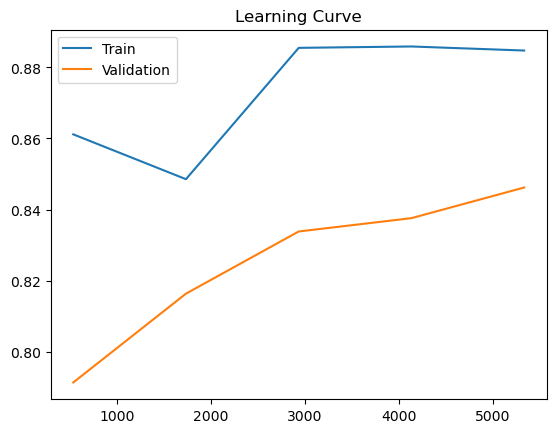

In [19]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model_2, X_train, y_train_2, cv=3)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
plt.legend()
plt.title("Learning Curve")
plt.show()


Training accuracy is higher than validation at the beginning. Signs of underfitting on small amounts of data.

Both curves increase with data size and stabilize after 3,000 samples.
The gap between training accuracy (Train ~0.885) and validation accuracy (Validation ~0.845) is small. However, overfitting is visible. 

Validation accuracy reaches approximately 0.845 (84.5%).

The model shows bias and could potentially benefit from increased complexity (more hidden layers, as suggested by hyperparameter search) to achieve higher accuracy, as both curves have stabilized.

Displaying the plot for the model with 3 classes

c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Annam\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

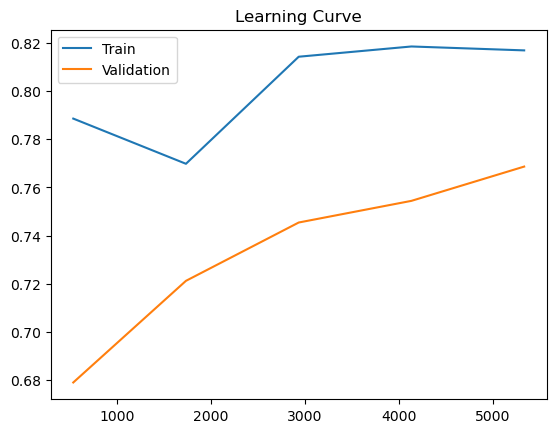

In [20]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model_3, X_train, y_train_3, cv=3)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation')
plt.legend()
plt.title("Learning Curve")
plt.show()


The training accuracy (Train) is much higher than the validation accuracy (Validation) from the outset. The model is under-trained on a small data set.
Both curves increase with data size, but the training curve stabilizes earlier (around 3,000 samples). 

Even at the end, there remains a significant gap between the two curves (Train ~0.82 vs Validation ~0.77). The model suffers from significant overfitting regardless of the volume of data. It memorizes the training data well but struggles to generalize.


Validation accuracy stagnates around 0.77 (77%).


To further improve performance, the model would need to be made more complex (more layers or neurons), or regularization techniques (such as dropout) would need to be added to reduce overfitting.

Displaying the confusion matrix

In [21]:
# For 2 classes
y_pred_2 = best_model_2.predict(X_test)

matrix_2 = confusion_matrix(y_test_2, y_pred_2)
print("Confusion Matrix:")
print(matrix_2)

report_2 = classification_report(y_test_2, y_pred_2)
print("Classification Report:")
print(report_2)


# For 3 classes
y_pred_3 = best_model_3.predict(X_test)


matrix_3 = confusion_matrix(y_test_3, y_pred_3)
print("Confusion Matrix:")
print(matrix_3)


report_3 = classification_report(y_test_3, y_pred_3)
print("Classification Report:")
print(report_3)



Confusion Matrix:
[[1034  170]
 [ 136  660]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1204
           1       0.80      0.83      0.81       796

    accuracy                           0.85      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.85      0.85      0.85      2000

Confusion Matrix:
[[149 109   4]
 [ 37 737 168]
 [  0 129 667]]
Classification Report:
              precision    recall  f1-score   support

         bas       0.80      0.57      0.67       262
       moyen       0.76      0.78      0.77       942
       émevé       0.79      0.84      0.82       796

    accuracy                           0.78      2000
   macro avg       0.78      0.73      0.75      2000
weighted avg       0.78      0.78      0.77      2000



## For 2 classes :

The support indicates that the test set was slightly unbalanced (1,204 samples for class 0, compared to 796 for class 1).

The model has better accuracy for class 0 (0.88) than for class 1 (0.80). This means that when it predicts class 0, it is correct 88% of the time.

The performance is relatively good and balanced. The F1-score is a good indicator of the balance between Precision and Recall, and it is slightly better for class 0 (0.87) than for class 1 (0.81).

## For 3 classes : 
Overall accuracy is lower than in the binary case (0.78 vs. 0.85), which is to be expected as the task is more difficult.

The model has poor recall performance for the ‘low’ class (0.57). This means that only 57% of samples that are actually ‘low’ were identified as such. Examination of the matrix reveals that the majority of unidentified ‘low’ samples are confused with ‘medium’ (109 errors out of 262).

 The ‘emévé’ class is the best identified in terms of recall (0.84) and has the best F1 score (0.82).






Confusion matrix graph for 2 classes

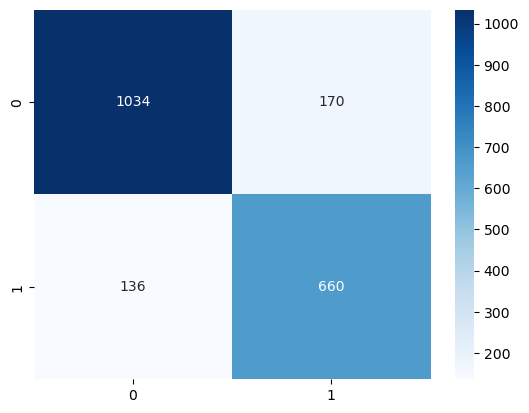

In [22]:
#For 2 classes
sns.heatmap(matrix_2, annot=True, fmt='d', cmap='Blues')
plt.show()

Confusion matrix graph for 3 classes

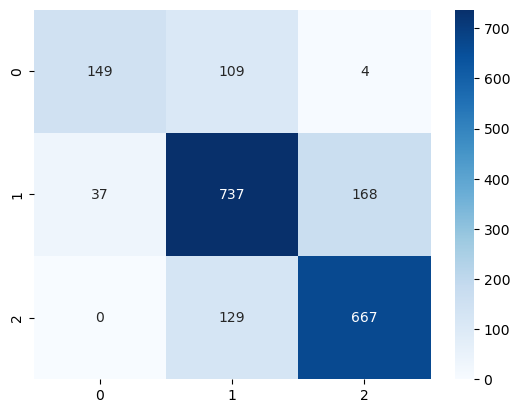

In [23]:
#for 3 classes
sns.heatmap(matrix_3, annot=True, fmt='d', cmap='Blues')
plt.show()

2.1.7 Comparison with TP 2

In the binary classification task, both models achieved excellent results, but the MLP is slightly ahead:

Binary MLP: Achieves the best accuracy at 0.85 (85%).

RandomForest (result from TP 2): Achieves a very close accuracy at 0.84 (84%).

The MLP has a slightly higher overall performance, but RandomForest is more balanced in terms of metrics between the two classes, particularly for class 1 recall (0.85 for RF versus 0.83 for MLP). Both models are reliable choices for binary classification on this dataset.

The increased complexity of the three-class classification (low, medium, high) led to a noticeable drop in performance for the MLP model:
- Accuracy (MLP 3 Classes): Drops to 0.78 (78%).
- F1-Score (Macro): Decreased to 0.75.

The main difficulty lies in the low Recall of the ‘low’ class (0.57). This means that the model only manages to correctly identify just over half of the ‘low’ samples, mainly confusing them with the ‘medium’ class.

The MLP demonstrated slight superiority for the binary task, but was more sensitive to the increase in task complexity. RandomForest proved to be extremely robust and balanced for binary classification.

To improve the performance of the MLP in multi-class classification, the focus should be on improving the detection of the ‘low’ class, perhaps by: Applying

## Partie 2

2.2 Entrâinement d'un classeur d'images avec un réseau de neurones concolutif en utilisant Keras

Imports

In [10]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import random
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2



In [11]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

Creation of test and training data for Keras (CNN) and Keras MLP

In [12]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# standardization
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn  = X_test.reshape(-1, 28, 28, 1)

y_train_cat = to_categorical(y_train, 10)
y_test_cat  = to_categorical(y_test, 10)

print("Shapes:")
print("X_train:", X_train.shape, "X_train_cnn:", X_train_cnn.shape)
print("X_test:", X_test.shape, "X_test_cnn:", X_test_cnn.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)


Shapes:
X_train: (60000, 28, 28) X_train_cnn: (60000, 28, 28, 1)
X_test: (10000, 28, 28) X_test_cnn: (10000, 28, 28, 1)
y_train: (60000,) y_test: (10000,)


2.2.1 Run the provided Keras MLP

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7536 - loss: 0.7105 - val_accuracy: 0.8546 - val_loss: 0.4213
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8618 - loss: 0.3891 - val_accuracy: 0.8650 - val_loss: 0.3774
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8772 - loss: 0.3429 - val_accuracy: 0.8705 - val_loss: 0.3583
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8850 - loss: 0.3163 - val_accuracy: 0.8761 - val_loss: 0.3415
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8928 - loss: 0.2936 - val_accuracy: 0.8777 - val_loss: 0.3424
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8974 - loss: 0.2762 - val_accuracy: 0.8803 - val_loss: 0.3331
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9023 - loss: 0.2615 - val_accuracy: 0.8811 - val_loss: 0.3311
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9085 - loss: 0.2495 - val_accuracy: 0.

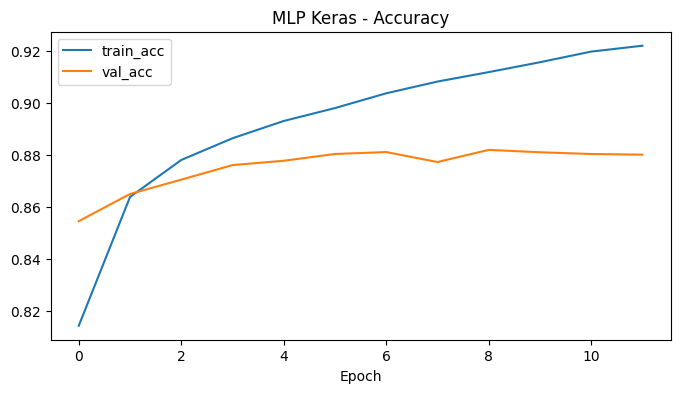

MLP Keras - Test accuracy: 0.875 - Training time (s): 16.9


In [15]:
mlp_keras = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

mlp_keras.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early stopping to avoid long execution times
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

start_time = time.time()
history_mlp_keras = mlp_keras.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=[es],
    verbose=1
)
time_mlp_keras = time.time() - start_time

plt.figure(figsize=(8,4))
plt.plot(history_mlp_keras.history['accuracy'], label='train_acc')
plt.plot(history_mlp_keras.history['val_accuracy'], label='val_acc')
plt.title('MLP Keras - Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

loss_mlp_keras, acc_mlp_keras = mlp_keras.evaluate(X_test, y_test_cat, verbose=0)
print("MLP Keras - Test accuracy:", acc_mlp_keras, "- Training time (s):", round(time_mlp_keras,1))



2.2.2 Reimplementing MLP with scikit-learn

In [24]:
# Flatten + MinMax scaling
X_train_flat = X_train.reshape(-1, 784)
X_test_flat  = X_test.reshape(-1, 784)

scaler = MinMaxScaler()
X_train_flat_scaled = scaler.fit_transform(X_train_flat)
X_test_flat_scaled  = scaler.transform(X_test_flat)

mlp_sklearn = MLPClassifier(
    hidden_layer_sizes=(256,128),
    activation='relu',
    solver='adam',
    batch_size=128,
    max_iter=40,
    random_state=seed,
    verbose=True
)

start_time = time.time()
mlp_sklearn.fit(X_train_flat_scaled, y_train)
time_mlp_sklearn = time.time() - start_time

y_pred_sklearn = mlp_sklearn.predict(X_test_flat_scaled)
acc_mlp_sklearn = accuracy_score(y_test, y_pred_sklearn)
print("MLP scikit-learn - Test accuracy:", acc_mlp_sklearn, "- Training time (s):", round(time_mlp_sklearn,1))



Iteration 1, loss = 0.51707283
Iteration 2, loss = 0.36668546
Iteration 3, loss = 0.33068635
Iteration 4, loss = 0.30486427
Iteration 5, loss = 0.28704369
Iteration 6, loss = 0.27035936
Iteration 7, loss = 0.25769797
Iteration 8, loss = 0.24973725
Iteration 9, loss = 0.23786565
Iteration 10, loss = 0.23201955
Iteration 11, loss = 0.21960928
Iteration 12, loss = 0.21653159
Iteration 13, loss = 0.20489307
Iteration 14, loss = 0.19846687
Iteration 15, loss = 0.19201898
Iteration 16, loss = 0.18653147
Iteration 17, loss = 0.17794287
Iteration 18, loss = 0.17121903
Iteration 19, loss = 0.16476867
Iteration 20, loss = 0.16160551
Iteration 21, loss = 0.15738195
Iteration 22, loss = 0.15505876
Iteration 23, loss = 0.14443708
Iteration 24, loss = 0.14497410
Iteration 25, loss = 0.13954007
Iteration 26, loss = 0.13491471
Iteration 27, loss = 0.12729609
Iteration 28, loss = 0.12699318
Iteration 29, loss = 0.12201463
Iteration 30, loss = 0.11889003
Iteration 31, loss = 0.11487523
Iteration 32, los

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP scikit-learn - Test accuracy: 0.8868 - Training time (s): 225.1


2.2.3 Comparison between scikit-learn and Keras

The scikit-learn MLP achieved a higher test accuracy (0.8868) than the Keras MLP (0.875). The scikit-learn model generalized better to the test data, which could be due to different default hyperparameters, a different stopping (convergence) strategy, or the optimizer used.

The Keras MLP is extremely fast, taking only 16.9 seconds. Keras (which typically uses TensorFlow or PyTorch in the background) is optimized for fast computation, often leveraging GPU acceleration or efficient vector operations.
The scikit-learn MLP is very slow, taking 225.1 seconds (more than 13 times longer than Keras). Scikit-learn is typically implemented on CPU architectures and its solver is optimized differently.  For very similar performance, the Keras MLP is by far the most efficient and fastest choice for training.

The training accuracy of Keras (train_acc, blue curve) continues to increase sharply to around 0.92, while the validation accuracy (val_acc, orange curve) stagnates and plateaus around 0.88. * Performance ceiling: Val_acc reaches its ceiling quickly. Even though the model continues to learn from the training data, it no longer generalizes better. The Keras MLP is therefore overfitting. If the Keras model had been better regularized (e.g., with Dropout or an early stopping strategy), it could potentially have achieved the accuracy of scikit-learn while maintaining its speed.

In summary, the scikit-learn MLP achieved better final performance, but the Keras MLP performed almost as well in a fraction of the time.

2.2.4 Construction of a CNN without augmentation or transfer

In [17]:
def build_cnn(input_shape=(28,28,1), n_classes=10):
    model = Sequential()
    # Bloc 1
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    # Bloc 2
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    # Top
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    return model

cnn = build_cnn()
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

es_cnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

start_time = time.time()
history_cnn = cnn.fit(
    X_train_cnn, y_train_cat,
    validation_split=0.2,
    epochs=40,
    batch_size=128,
    callbacks=[es_cnn],
    verbose=1
)
time_cnn = time.time() - start_time


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,586 (1.79 MB)

 Trainable params: 468,202 (1.79 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6974 - loss: 0.9096 - val_accuracy: 0.3010 - val_loss: 2.5186
Epoch 2/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8465 - loss: 0.4231 - val_accuracy: 0.8919 - val_loss: 0.2923
Epoch 3/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8683 - loss: 0.3640 - val_accuracy: 0.8951 - val_loss: 0.2824
Epoch 4/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8840 - loss: 0.3188 - val_accuracy: 0.9112 - val_loss: 0.2435
Epoch 5/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8903 - loss: 0.2964 - val_accuracy: 0.9096 - val_loss: 0.2445
Epoch 6/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8995 - loss: 0.2755 - val_accuracy: 0.9087 - val_loss: 0.2452
Epoch 7/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9031 - loss: 0.2688 - val_accuracy: 0.9194 - val_loss: 0.2209
Epoch 8/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9089 - loss: 0.2497 - val_acc

2.2.5 Plot of the CNN

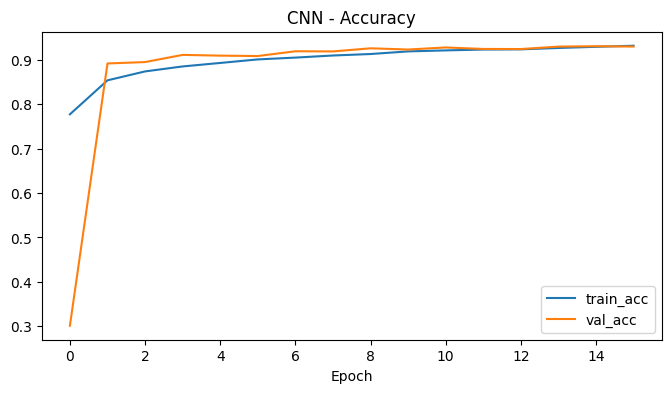

CNN - Test accuracy: 0.9262999892234802 - Training time (s): 76.9


In [18]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['accuracy'], label='train_acc')
plt.plot(history_cnn.history['val_accuracy'], label='val_acc')
plt.title('CNN - Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

loss_cnn, acc_cnn = cnn.evaluate(X_test_cnn, y_test_cat, verbose=0)
print("CNN - Test accuracy:", acc_cnn, "- Training time (s):", round(time_cnn,1))


The graph shows the evolution of the accuracy of a Convolutional Neural Network (CNN) model over epochs (training cycles).
The two curves show:
- train_acc (Training accuracy): The accuracy measured on the training data set.
- val_acc (Validation accuracy): The accuracy measured on a validation dataset, which is data that the model has never seen during training.

Both accuracies increase very rapidly during the first epochs (from 0 to around 2), which is typical of good initial learning.

Both curves reach a high plateau around 0.92, indicating that the model is performing very well.

In this graph, the val_acc (validation) curve is slightly higher than or closely follows the train_acc (training) curve after epoch 2.

This suggests that the model generalizes well to new data, as it performs similarly on validation data and training data.

2.2.6 Construction of a CNN with augmentation

Epoch 1/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 36s 59ms/step - accuracy: 0.6161 - loss: 1.1454 - val_accuracy: 0.6409 - val_loss: 1.0722
Epoch 2/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7656 - loss: 0.7214 - val_accuracy: 0.6460 - val_loss: 1.0610
Epoch 3/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.7748 - loss: 0.6030 - val_accuracy: 0.8339 - val_loss: 0.4393
Epoch 4/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.4340 - val_accuracy: 0.8329 - val_loss: 0.4411
Epoch 5/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.8064 - loss: 0.5296 - val_accuracy: 0.8721 - val_loss: 0.3498
Epoch 6/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8203 - loss: 0.4834 - val_accuracy: 0.8751 - val_loss: 0.3491
Epoch 7/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.8245 - loss: 0.4810 - val_accuracy: 0.8803 - val_loss: 0.3415
Epoch 8/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8047 - loss: 0.4996 - val_accu

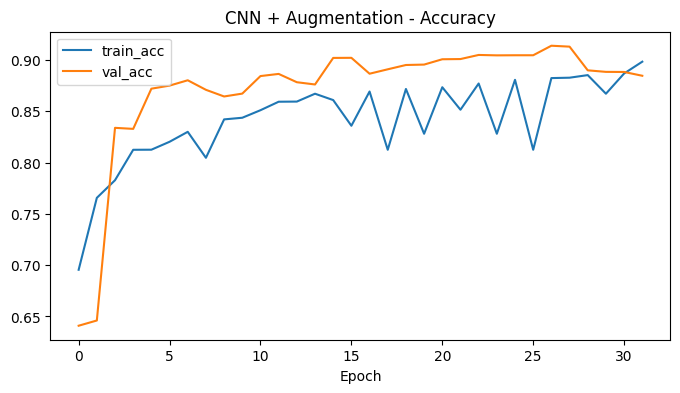

In [20]:
datagen = ImageDataGenerator(
    rotation_range=12,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08,
    shear_range=0.02,
    horizontal_flip=True
)

# Fit only if featurewise_center/scale used
batch_size = 128
train_gen = datagen.flow(X_train_cnn, y_train_cat, batch_size=batch_size, seed=seed)

# Re-build same architecture from scratch for fair comparison
cnn_aug = build_cnn()
cnn_aug.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es_aug = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

start_time = time.time()
history_aug = cnn_aug.fit(
    train_gen,
    steps_per_epoch = len(X_train_cnn)//batch_size,
    validation_data = (X_test_cnn, y_test_cat),
    epochs = 40,
    callbacks = [es_aug],
    verbose = 1
)
time_cnn_aug = time.time() - start_time

loss_cnn_aug, acc_cnn_aug = cnn_aug.evaluate(X_test_cnn, y_test_cat, verbose=0)
print("CNN + Augmentation - Test accuracy:", acc_cnn_aug, "- Training time (s):", round(time_cnn_aug,1))

plt.figure(figsize=(8,4))
plt.plot(history_aug.history['accuracy'], label='train_acc')
plt.plot(history_aug.history['val_accuracy'], label='val_acc')
plt.title('CNN + Augmentation - Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

This graph shows the evolution of the accuracy of a Convolutional Neural Network (CNN) trained using the Data Augmentation technique, which consists of generating new synthetic training data from existing data (rotations, flips, zooms, etc.).
The most notable feature is that validation accuracy (val_acc, orange curve) is consistently higher than training accuracy (train_acc, blue curve) throughout most of the training process.
This is often a sign that the training data is much more difficult or noisier than the validation set, or that the increase in data makes the training examples very varied, which increases the “noise” in the training curve.

The train_acc curve is very irregular.
This high fluctuation is a typical consequence of data augmentation and the use of small batch sizes. The model sees a new, modified version of each image at each step, causing instability in the gradients and, consequently, in the accuracy measured per epoch.

Despite the large difference between the two curves, there is no sign of classic overfitting. The increase in data has effectively regularized the model, allowing it to achieve high generalization performance despite the difficulty of optimizing the increased training set.

2.2.7 Construction of a CNN with transfer

/tmp/ipython-input-3613652415.py:35: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.7343 - loss: 0.7839 - val_accuracy: 0.8537 - val_loss: 0.3946
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8326 - loss: 0.4653 - val_accuracy: 0.8717 - val_loss: 0.3461
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8484 - loss: 0.4235 - val_accuracy: 0.8770 - val_loss: 0.3346
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8566 - loss: 0.3983 - val_accuracy: 0.8809 - val_loss: 0.3181
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8599 - loss: 0.3890 - val_accuracy: 0.8869 - val_loss: 0.3035
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8659 - loss: 0.3654 - val_accuracy: 0.8869 - val_loss: 0.3210
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8662 - loss: 0.3653 - val_accuracy: 0.8917 - val_loss: 0.2927
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8674 -

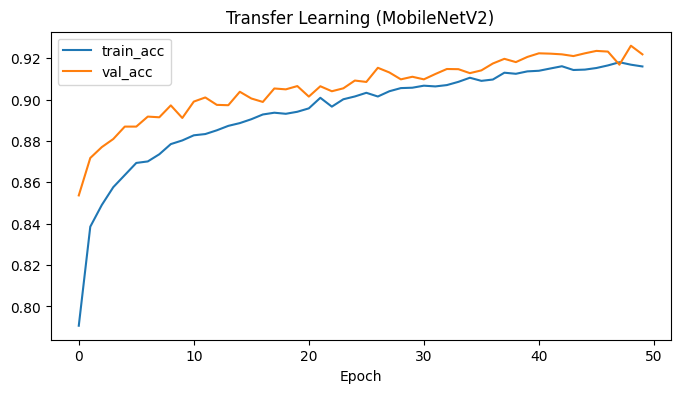

In [7]:
# Loading of Fashion MNIST
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Standardisation
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

y_train_cat = to_categorical(y_train, 10)
y_test_cat  = to_categorical(y_test, 10)

IMG_SIZE = (70, 70)
BATCH_SIZE = 32

def preprocess(image, label):
    # grayscale → RGB
    image = tf.image.grayscale_to_rgb(image)
    # resize
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = train_ds.take(int(0.2 * len(X_train) / BATCH_SIZE))
train_ds2 = train_ds.skip(int(0.2 * len(X_train) / BATCH_SIZE))

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(70,70,3)
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

model_tl = Model(inputs=base_model.input, outputs=output)

model_tl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

start = time.time()

history_tl = model_tl.fit(
    train_ds2,
    validation_data=val_ds,
    epochs=50,
    callbacks=[es],
    verbose=1
)

train_time = time.time() - start

loss_tl, acc_tl = model_tl.evaluate(test_ds, verbose=0)
print("Test accuracy:", acc_tl)
print("Training time (s):", round(train_time,1))

plt.figure(figsize=(8,4))
plt.plot(history_tl.history['accuracy'], label="train_acc")
plt.plot(history_tl.history['val_accuracy'], label="val_acc")
plt.title("Transfer Learning (MobileNetV2)")
plt.xlabel("Epoch")
plt.legend()
plt.show()



This graph illustrates the training of a model using Transfer Learning, specifically based on the MobileNetV2 architecture. This technique involves taking a model that has been pre-trained on a large task (such as ImageNet) and adapting it to a new task with new data.

Training begins with an already high validation accuracy (val_acc) of around 0.855. This is a hallmark of Transfer Learning: the model has already learned relevant features from its initial task.

Consistently across all 50 epochs, the validation accuracy (val_acc, orange curve) remains higher than the training accuracy (train_acc, blue curve).

As in the previous analysis, this suggests that the training data is inherently more difficult or more variable than the validation data. In the context of Transfer Learning, this may also indicate that regularization is very effective during training.

Both accuracies are progressing steadily.

The model demonstrates very good generalization ability. The final test accuracy rate is approximately 0.889, which is slightly lower than the maximum validation accuracy observed, possibly indicating a small amount of overfitting, but this remains a solid performance for the new task.

2.2.8 Comparison between models

                             Model  Test Accuracy  Training Time (s)
0                        MLP Keras         0.8750          16.861793
1                 MLP scikit-learn         0.8868         225.110062
2                     CNN (no aug)         0.9263          76.891611
3               CNN + Augmentation         0.9140         400.908747
4  Transfer Learning (MobileNetV2)         0.8900         944.631052


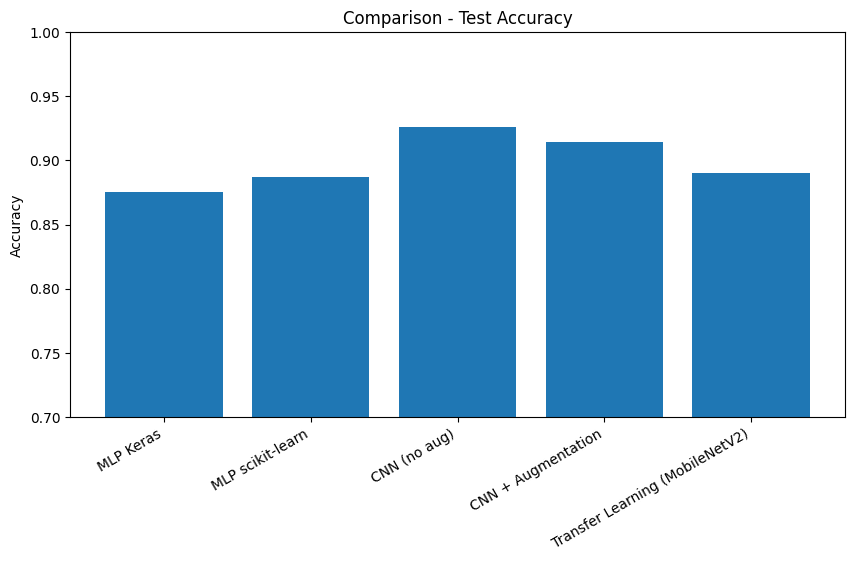

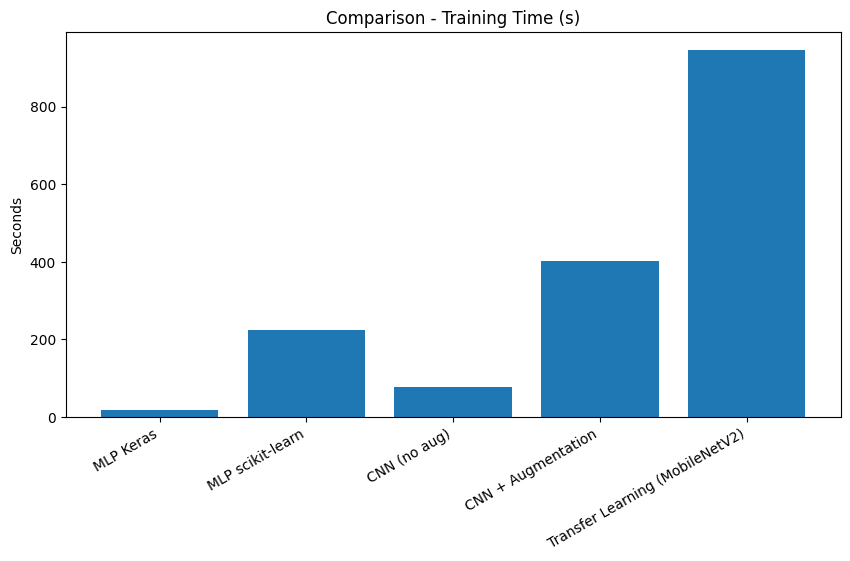

Résultats sauvegardés dans fashion_mnist_model_comparison.csv


In [25]:
results = pd.DataFrame({
    'Model': [
        'MLP Keras',
        'MLP scikit-learn',
        'CNN (no aug)',
        'CNN + Augmentation',
        'Transfer Learning (MobileNetV2)'
    ],
    'Test Accuracy': [
        acc_mlp_keras,
        acc_mlp_sklearn,
        acc_cnn,
        acc_cnn_aug,
        acc_tl
    ],
    'Training Time (s)': [
        time_mlp_keras,
        time_mlp_sklearn,
        time_cnn,
        time_cnn_aug,
        train_time
    ]
})

print(results)

# Accuracy comparison histogram
plt.figure(figsize=(10,5))
plt.bar(results['Model'], results['Test Accuracy'])
plt.ylim(0.7,1.0)
plt.xticks(rotation=30, ha='right')
plt.title('Comparison - Test Accuracy')
plt.ylabel('Accuracy')
plt.show()

# Time comparison histogram
plt.figure(figsize=(10,5))
plt.bar(results['Model'], results['Training Time (s)'])
plt.xticks(rotation=30, ha='right')
plt.title('Comparison - Training Time (s)')
plt.ylabel('Seconds')
plt.show()

# Save just in case
results.to_csv('fashion_mnist_model_comparison.csv', index=False)
print("Résultats sauvegardés dans fashion_mnist_model_comparison.csv")

These graphs compare five machine learning and deep learning approaches based on two key metrics: Test Accuracy and Training Time.

The best model is CNN (no aug), with an accuracy of 92.63%. This indicates that the standard CNN architecture (without data augmentation) was best suited to the specific data.

Deep learning models dominate: The top three models are variations of deep neural networks (CNN and transfer learning).

MLPs perform the worst: Multi-Layer Perceptrons (MLPs) perform significantly worse, confirming that CNNs are generally better for image classification tasks.

Augmentation slightly degraded performance: Adding data augmentation caused the CNN's accuracy to drop from 0.9263 to 0.9140. This may indicate that the data augmentation used was too aggressive or unnecessary for this dataset.

Transfer learning is robust: MobileNetV2 achieved 0.8900, a respectable performance, especially for a pre-trained model, but did not outperform the CNN trained from scratch.

Training time measures efficiency and the computing resources required.

The fastest is Keras MLP (16.86 s). MLP, being a simpler architecture, trains much faster.

CNN (no aug) is a good compromise (76.89 s). It is the second fastest deep learning model, but offers the best accuracy. It is the most efficient option in terms of performance/time ratio.

The slowest models: CNN + Augmentation and Transfer Learning are by far the slowest, mainly due to two factors:

Augmentation requires additional computing time to generate new images at each epoch (400.9 s).

Transfer Learning involves fine-tuning a very large number of parameters in MobileNetV2 (944.6 s), which is the most time-consuming.

In conclusion, CNN (no augmentation) is the model that achieved the best balance between high accuracy (92.63%) and low training time (76.89 s) compared to other deep learning models.
